## Computing CO cross section using HITRAN (opacity calculator = LPF)

This tutorial demonstrates how to compute the opacity of CO using HITRAN step by step, not using `opa`.

In [1]:
from jax import config
config.update("jax_enable_x64", True)

In [2]:
from exojax.database.hitran  import line_strength, doppler_sigma, gamma_hitran, gamma_natural
from exojax.database import api 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

First of all, set a wavenumber bin in the unit of wavenumber (cm-1).
Here we set the wavenumber range as $1000 \le \nu \le 10000$ (1/cm) with the resolution of 0.01 (1/cm). 

We call moldb instance with the path of par file.
If the par file does not exist, moldb will try to download it from HITRAN website.

In [3]:
# Setting wavenumber bins and loading HITRAN database
nu_grid = np.linspace(2000.0, 2150.0, 150000, dtype=np.float64)  #cm-1
isotope = 1
mdbCO = api.MdbHitran('CO', nu_grid, isotope=isotope, gpu_transfer=True)

radis engine =  vaex


Define molecular weight of CO ($\sim 12+16=28$), temperature (K), and pressure (bar).
Also, we here assume the 100 % CO atmosphere, i.e. the partial pressure = pressure.  

In [4]:
mean_molecular_weight=28.0 # molecular weight
Tfix=1000.0 # we assume T=1000K
Pfix=1.e-3 # we compute P=1.e-3 bar
Ppart=Pfix #partial pressure of CO. here we assume a 100% CO atmosphere. 

partition function ratio $q(T)$ is defined by 

$q(T) = Q(T)/Q(T_{ref})$; $T_{ref}$=296 K

Here, we use the partition function in mdb

In [6]:
from exojax.utils.constants import Tref_original
qt=mdbCO.qr_interp(isotope,Tfix, Tref_original)

Let us compute the line strength S(T) at temperature of Tfix.

$S (T;s_0,\nu_0,E_l,q(T)) = S_0 \frac{Q(T_{ref})}{Q(T)} \frac{e^{- h c E_l /k_B T}}{e^{- h c E_l /k_B T_{ref}}} \frac{1- e^{- h c \nu /k_B T}}{1-e^{- h c \nu /k_B T_{ref}}}= q_r(T)^{-1} e^{ s_0 - c_2 E_l (T^{-1} - T_{ref}^{-1})}  \frac{1- e^{- c_2 \nu_0/ T}}{1-e^{- c_2 \nu_0/T_{ref}}}$

$s_0=\log_{e} S_0$ : logsij0

$\nu_0$: nu_lines

$E_l$ : elower

Why the input is $s_0 = \log_{e} S_0$ instead of $S_0$ in SijT? This is because the direct value of $S_0$ is quite small and we need to use float32 for jax.  

In [7]:
Sij=line_strength(Tfix,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt,Tref_original)

Then, compute the Lorentz gamma factor (pressure+natural broadening)

$\gamma_L = \gamma^p_L + \gamma^n_L$

where the pressure broadning 

$\gamma^p_L = (T/296K)^{-n_{air}} [ \alpha_{air} ( P - P_{part})/P_{atm} + \alpha_{self} P_{part}/P_{atm}]$

$P_{atm}$: 1 atm in the unit of bar (i.e. = 1.01325)

and the natural broadening

$\gamma^n_L = \frac{A}{4 \pi c}$

In [8]:
gammaL = gamma_hitran(
    Pfix, Tfix, Ppart, mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self
) + gamma_natural(mdbCO.A)

Thermal broadening

$\sigma_D^{t} = \sqrt{\frac{k_B T}{M m_u}} \frac{\nu_0}{c}$

In [9]:
# thermal doppler sigma
sigmaD = doppler_sigma(mdbCO.nu_lines, Tfix, mean_molecular_weight)

Then, the line center...

In HITRAN database, a slight pressure shift can be included using $\delta_{air}$:
$\nu_0(P) = \nu_0 + \delta_{air} P$. But this shift is quite a bit. 

In [10]:
#line center
nu0=mdbCO.nu_lines
#Use below if you wanna include a slight pressure line shift
#nu0=mdbCO.nu_lines+mdbCO.delta_air*Pfix 

ExoJAX contains several opacity calculators. The most primitive one is Direct LPF (line profile). 
You can use OpaDirect for Direct LPF, but here we manually call functions used in Direct LPF.
Each of these opacity calculators requires unique initial information. `spec.initspec` module contains the initialization procedures for the calculators. 

In [11]:
from exojax.opacity.initspec import init_lpf
from exojax.opacity.lpf import xsvector

numatrix = init_lpf(mdbCO.nu_lines, nu_grid)
xsv = xsvector(numatrix, sigmaD, gammaL, Sij)

Plot it!

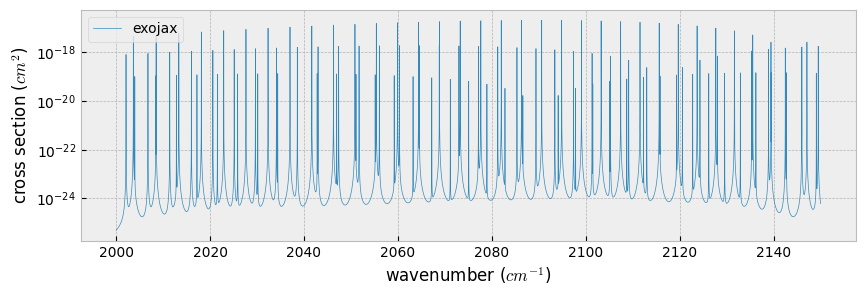

In [12]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)
plt.plot(nu_grid,xsv,lw=0.5,label="exojax")
plt.yscale("log")
plt.xlabel("wavenumber ($cm^{-1}$)")
plt.ylabel("cross section ($cm^{2}$)")
plt.legend(loc="upper left")
plt.savefig("co_hitran.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

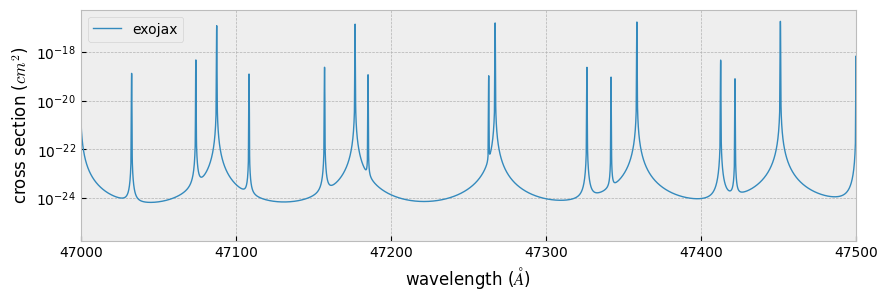

In [13]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)
plt.plot(1.e8/nu_grid,xsv,lw=1,label="exojax")
plt.yscale("log")
plt.xlabel("wavelength ($\AA$)")
plt.ylabel("cross section ($cm^{2}$)")
plt.xlim(47000.,47500)
plt.legend(loc="upper left")
plt.savefig("co_hitran.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()